# Nowcasting with Rainymotion

This is a little example about how to use [Rainymotion](https://github.com/hydrogo/rainymotion) for nowcasting precipitation. It complements the examples proposed on his documentation. Unfortunately, Rainymotion has no conda distribution yet and be installed by download of repository. 

Import libraries

In [1]:
import rainymotion
import numpy as np
import matplotlib.pyplot as plt

Read the file. In this case, data has archived using ".h5py" extension. It could be open using **`h5py`** library. 

In [2]:
import h5py

In [3]:
f = h5py.File("./data/14052019.hdf5", "r")
a_group_key = list(f.keys())[0]
data = f[a_group_key]
data = np.array(data).astype('float')
f.close()

Data corresponds a PPI scan of X-band radar of Peru. It contains reflectivity values(dBZ) of a drizzly of 14/05/2019.

In [4]:
data.shape

(15, 2000, 2000)

How you can see, temporal axis corresponds axis 0. This is the standart in Rainymotion and Pysteps.

In [5]:
from matplotlib import animation
from IPython.display import HTML

ims = []
fig = plt.figure(figsize=(6,6))

for i in range(data.shape[0]):
    im = plt.imshow(data[i, ...], vmax=40, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

For this example, we select the seventh for the nowcasting. Unlike Pysteps, Rainymotion uses a scheme based on classes. All classes has default values that makes easy to use. 

In [6]:
n_leadtimes = 8

In [7]:
def depth2intensity(depth, interval=300):
    return depth * 3600 / interval


def intensity2depth(intensity, interval=300):
    return intensity * interval / 3600


def mmh2rfl(r, a=256., b=1.42):
    return a * r ** b


def rfl2dbz(z):
    return 10. * np.log10(z)


def dbz2rfl(d):
    return 10. ** (d / 10.)


def rfl2mmh(z, a=256., b=1.42):
    return (z / a) ** (1. / b)

Transformate data to rainfall rate.  Rainymotion uses by default **`a=256.`**, **`b=1.6`** on Z-r relation. Here we use Marshall-Palmer relations.

In [8]:
Z = dbz2rfl(data)
R = rfl2mmh(Z, a=250., b=1.6)

Exclude NaN values. Now, Rainymotion have no deal with NaN.

In [9]:
R_out = R.copy()
R_out[np.isnan(R)] = 0

Select the model. Rainymotion has 5 models available(Sparse, SparseSD, Dense, DenseRotation and Persistence). The first two, detect features to track and calculate matrix transformation. This models no calculate velocity. Instead, Dense and DenseRotation calculates velocity field from Optical Flow methods. The difference between Dense and DenseRotation is about how to extrapolate velocity field. Dense uses Constant vector and DenseRotation uses semi-Lagrangian scheme.
Last, Persistence is Eulerian Persistence, a trivial case thats simply mantains the last frame from extrapolation. 

Here, we use DenseRotation model. Now, you can change default values using atributes of class. See documentation for further details.

In [10]:
model = rainymotion.models.DenseRotation()
R_used = R_out[0:7, ...]            # Select seventh data
model.input_data = R_used[-3:, :, :]       # Give just the last three frames for calculating velocity field      
model.lead_steps = n_leadtimes
R_nowcast = model.run()

If we want, we can back transformate to reflectivity(dbz)

In [11]:
Z_nowcast = mmh2rfl(R_nowcast, a=250, b=1.6)
dbz_nowcast = rfl2dbz(Z_nowcast)

C:\Users\Elmer Lopez Ramirez\Anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


Add NaN values and use a threshold of -31.5 dbz because it's the minimal value of reflectivity on my data.

In [12]:
R_nowcast[R_nowcast < 0. ] = 0.
R_nowcast[np.isinf(R_nowcast) ] = 0.
R_nowcast[:, np.isnan(R[0, ...])] = np.nan


dbz_nowcast[dbz_nowcast < -31.5 ] = -31.5
dbz_nowcast[np.isinf(dbz_nowcast) ] = -31.5
dbz_nowcast[:, np.isnan(R[0, ...])] = np.nan

Rainymotion has no options for visualization. But, easily can use **`plt.imshow()`**

In [14]:
fig = plt.figure(figsize=(6,6))
ims = []

R_used[:, np.isnan(R[0, ...])] = np.nan
# Data
for i in range(R_used.shape[0]):
    im = plt.imshow(R_used[i, ...], vmax=2, animated=True)      # Original data
    ims.append([im])

# Nowcasting
for i in range(n_leadtimes):
    im = plt.imshow(R_nowcast[i, ...], vmax=2, animated=True)    # Nowcasting 
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

Rainymotions offers methods for comparison in his module **`rainymotion.metrics`**. Here, we use Critical Success Index(CSI)

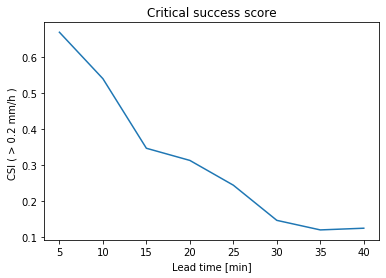

In [21]:
timestep = 5     # Time interval in minutes
thr = 0.2        # Threshold for the method
score = []

# Dealing with NaN
R_nowcast[np.isnan(R_nowcast)] = 0
R [np.isnan(R)] = 0

for i in range(n_leadtimes):
    score.append(rainymotion.metrics.CSI(R_nowcast[i, :, :], R[7 + i, :, :], threshold=thr))

plt.figure()
x = np.arange(1, n_leadtimes + 1) * timestep
plt.plot(x, score)
plt.xlabel("Lead time [min]")
plt.ylabel("CSI ( > 0.2 mm/h ) ")
plt.title("Critical success score")
plt.show()

Results could seem a bit disappointing. But if you see the video, in this example, precipitation doesn't decorrelated easily with time because his lifetime is very short. 